# Lab x: Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this lab, we train an image generation model using diffusion. The diffusion model is trained to remove noise from images, so when it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

## Grading Criteria
- Scheduling (10%)
- Forward Diffusion (30%)
- Backward Diffusion (30%)
- Image Generation (20%)
- Answers to Questions (10%)

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672


We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models"

In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
image_size = 32
lr = .0001

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


In [4]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


In [5]:
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

# Part 1: Implement a linear and cosine scheduler
They should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$

In [13]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    # Linear schedule from β1=10^-4 to βT = 0.02.
    b_1 = 0.001
    b_t = 0.02
    return torch.linspace(b_1, b_t, steps=timesteps)

def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = .008
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_bar = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process.

In [14]:
T = MAX_TIMESTEPS
betas = cosine_beta_schedule(T)
betas = torch.cat([torch.tensor([0]), betas]).to(device)
alphas = (1 - betas).to(device)
alphas_bar = torch.cumprod(alphas, axis=0).to(device)

# Part 2: Implement the forward diffusion (training) process

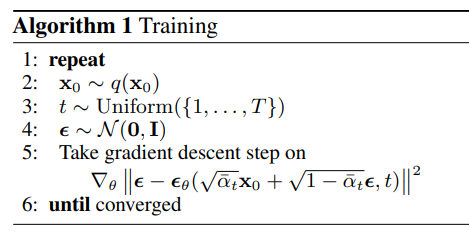

In [44]:
from tqdm import tqdm

def training(model, optimizer, dataloader, n_minibatches=1000):
    model.train()  # Let's the model know it is in training mode

    # Implement Algorithm 1 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    # 1000-2000 minibatches (i.e. optimization steps) is sufficient for learning how to generate images, but more will help make better images

    mse = nn.MSELoss()
    losses = list()
    NUM_EPOCHS = 2

    for epoch in range(NUM_EPOCHS):
      loop = tqdm(total=len(dataloader), position=0)
      for x_0, i in dataloader:
        x_0 = x_0.to(device)
        #
        t = torch.randint(low=1, high=T, size=(len(x_0),)).long().to(device)
        epsilon = torch.randn_like(x_0).to(device)
        #
        noised_images = (torch.sqrt(alphas_bar[t]) * x_0) + (torch.sqrt(1 - alphas_bar[t]) * epsilon)
        epsilon_theta = model(noised_images, t)
        #
        loss = mse(epsilon, epsilon_theta)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        loop.set_description("Epoch : {}, Loss: {:.4f}".format(epoch, losses[-1]))
        loop.update(1)
        optimizer.step()
      loop.close()

    return losses


# Part 3: Implement the backward diffusion (sampling) process

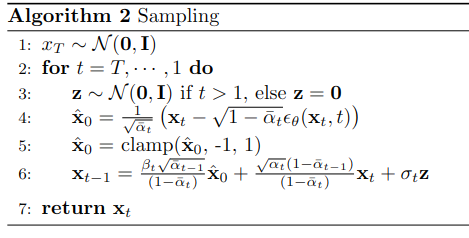

where $\bar{\alpha}_0 = 1$.

In [45]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()  # Let's the model know it is in validation mode

    # Implement Algorithm 2 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"

    x_T = torch.randn(batch_size, 1, image_size, image_size).to(device)
    x_t = x_T

    for t in range(T, 0, -1):
      if t > 1:
        z = torch.randn(batch_size, 1, image_size, image_size).to(device)
      else:
        z = 0
      #
      t_s = torch.tensor([t]*batch_size, dtype=torch.int).to(device)
      epsilon_theta = model(x_t, t_s)
      sigma = math.sqrt(betas[t])
      #
      x_0_til = (1 / torch.sqrt(alphas_bar[t])) * (x_t - torch.sqrt(1 - alphas_bar[t]) * epsilon_theta)
      x_0_til = torch.clamp(x_0_til, -1, 1)
      #
      x_t_1_pt1 = ((betas[t] * math.sqrt(alphas_bar[t-1])) / (1 - alphas_bar[t])) * x_0_til
      x_t_1_pt2 = (math.sqrt(alphas[t]) * (1 - alphas_bar[t-1])) / (1 - alphas_bar[t]) * x_t
      x_t_1_pt3 = sigma*z
      x_t = x_t_1_pt1 + x_t_1_pt2 + x_t_1_pt3

    return x_t

# Part 4: Train and generate images

In [46]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 32
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

In [47]:
losses = training(model, optimizer, dataloader)

Epoch : 1, Loss: 0.0578: 100%|██████████| 1875/1875 [01:33<00:00, 20.15it/s]


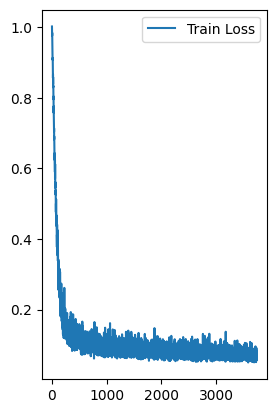

In [48]:
# plot your training loss
plt.subplot(121)
plt.plot(np.arange(len(losses)), losses, label='Train Loss')
plt.legend()
plt.show()

In [49]:
# Use sampling() to generate 16 images and plot them below
x_ts = sampling(model, 16)

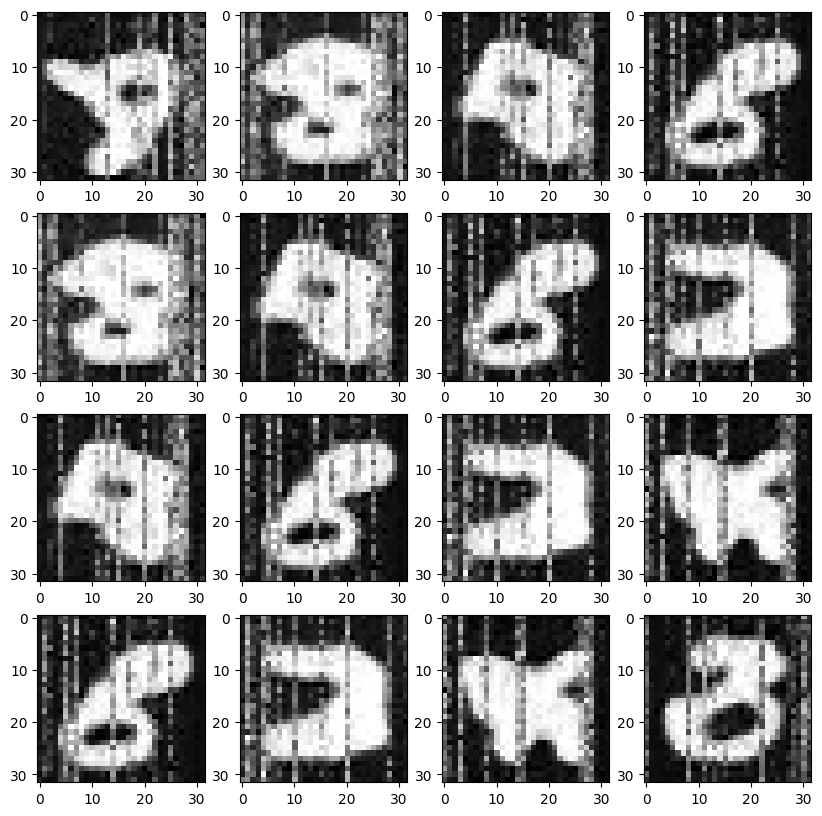

In [50]:
fig, axes = plt.subplots(4, 4, figsize=(10,10))

for i in range(4):
  for j in range(4):
    axes[i,j].imshow(x_ts[i+j, 0, :, :].cpu(), cmap='gray')

plt.show()

# Part 5: Questions

1. Where do we scale our training data? What range do we scale the data to? Why do we scale the data in that range?

2. Why is a forward process so efficient?

3. Why is the cosine scheduler better than the linear scheduler?

1

a The pre-process transform function.

b -1 to 1.

c Improves gradient descent, standardizes features, improves activation function behavior, provides numerical stability, and provides consistency with weight initialization.

2 The forward process in deep learning is efficient due to its ability to exploit the inherent structure of neural networks, enabling parallel computations and memory optimizations.

3 The cosine scheduler outperforms the linear scheduler due to its gradual reduction in learning rate, promoting better convergence and preventing overfitting.